# Pytorch Unet image segmentation

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset
import torchvision
import torchvision.transforms as transforms

In [2]:
import numpy as np
from glob import glob
from PIL import Image

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

## Import data

In [4]:
# the indicator of a fresh run
first_time_running = False

# user-specified working directory
filepath = '/glade/campaign/cisl/aiml/ksha/Pytorch_example_data/oxford_iiit/'

In [5]:
if first_time_running:
    # downloading and executing data files
    import tarfile
    import urllib.request
    
    filename_image = filepath+'images.tar.gz'
    filename_target = filepath+'annotations.tar.gz'
    
    urllib.request.urlretrieve('http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz', filename_image);
    urllib.request.urlretrieve('https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz', filename_target);
    
    with tarfile.open(filename_image, "r:gz") as tar_io:
        tar_io.extractall(path=filepath)
    with tarfile.open(filename_target, "r:gz") as tar_io:
        tar_io.extractall(path=filepath)

## Build model

In [6]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels1, in_channels2, out_channels):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = DoubleConv(in_channels1, out_channels)
        self.conv2 = DoubleConv(out_channels+in_channels2, out_channels)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x1 = self.conv1(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv2(x)
        return x

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        self.inc = (DoubleConv(n_channels, 64))
        
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        self.down4 = (Down(512, 1024))
        
        self.up1 = (Up(1024, 512, 512))
        self.up2 = (Up(512, 256, 256))
        self.up3 = (Up(256, 128, 128))
        self.up4 = (Up(128, 64, 64))
        
        self.outc = (OutConv(64, n_classes))
        #self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        #x = self.softmax(x)
        return x

In [7]:
# build model
model = UNet(n_channels=3, n_classes=3).to("cuda")

### Model config

In [8]:
# loss function
loss_func = nn.CrossEntropyLoss()
# optimizers
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

### Test model with an input tensor

In [9]:
# test model graph with a single tensor
input_tensor = torch.randn(2, 3, 256, 256).to("cuda")
y_pred = model(input_tensor)
print(y_pred.shape)

torch.Size([2, 3, 256, 256])


### Visualize model

```bash
pip install torchviz
pip install torchview
```

In [10]:
# Draw model (option 1)

# from torchviz import make_dot
# model = UNet(n_channels=3, n_classes=3).to("cuda")
# input_tensor = torch.randn(2, 3, 256, 256).to("cuda")
# y_pred = model(input_tensor)
# make_dot(y_pred.mean(), params=dict(list(model.named_parameters()))).render("unet_graph", format="png")

In [11]:
# Draw model (option 2)

# from torchview import draw_graph
# model = UNet(n_channels=3, n_classes=3).to("cuda")
# input_tensor = torch.randn(2, 3, 256, 256).to("cuda")
# model_graph = draw_graph(model, input_data=input_tensor, expand_nested=True, save_graph=True, filename='unet.png')
# model_graph.visual_graph

## Data pre-processing

In [12]:
def input_data_process(input_array):
    '''converting pixel vales to [0, 1]'''
    return input_array/255.

def shuffle_ind(L):
    ind = np.arange(L)
    np.random.shuffle(ind)
    return ind

def image_to_array(filenames, size, channel):
    # number of files
    L = len(filenames)
    
    # allocation
    out = np.empty((L, size, size, channel))
    
    # loop over filenames
    if channel == 1:
        for i, name in enumerate(filenames):
            with Image.open(name) as pixio:
                pix = pixio.resize((size, size), Image.NEAREST)
                out[i, ..., 0] = np.array(pix)
    else:
        for i, name in enumerate(filenames):
            with Image.open(name) as pixio:
                pix = pixio.resize((size, size), Image.NEAREST)
                out[i, ...] = np.array(pix)[..., :channel]
    return out[:, ::-1, ...]

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

In [13]:
sample_names = np.array(sorted(glob(filepath+'images/*.jpg')))
label_names = np.array(sorted(glob(filepath+'annotations/trimaps/*.png')))

L = len(sample_names)
ind_all = shuffle_ind(L)

L_train = int(0.96*L)
L_valid = int(0.02*L)
L_test = L - L_train - L_valid
ind_train = ind_all[:L_train]; ind_valid = ind_all[L_train:L_train+L_valid]; ind_test = ind_all[L_train+L_valid:]

print("Training:validation:testing = {}:{}:{}".format(L_train, L_valid, L_test))

Training:validation:testing = 7094:147:149


## Model training

In [17]:
N_sample = 64 # number of samples per batch

**Create dataloaders**

In [14]:
class base_loader(Dataset):

    def __init__(self, filename_input, filename_target, size, channel_input, channel_target):
        self.filename_input = filename_input
        self.filename_target = filename_target
        self.size = size
        self.channel_input = channel_input
        self.channel_target = channel_target

    def __len__(self):
        return len(self.filename_input)

    def __getitem__(self, index):

        # get single file names
        filename_input_single = [self.filename_input[index],]
        filename_target_single = [self.filename_target[index],]

        # get size info
        size = self.size
        channel_input = self.channel_input
        channel_target = self.channel_target

        # input preprocessing
        train_input = image_to_array(filename_input_single, size, channel_input)
        train_input = input_data_process(train_input)
        train_input = np.transpose(train_input, [0, 3, 1, 2])[0, ...]
        train_input = torch.from_numpy(train_input).float()

        # target preprocessing
        train_target = image_to_array(filename_target_single, size, channel_target)
        train_target = train_target[..., 0].astype(int)
        train_target = train_target - 1
        train_target = to_categorical(train_target, num_classes=3)
        train_target = np.transpose(train_target, [0, 3, 1, 2])[0, ...]
        train_target = torch.from_numpy(train_target.copy()).float()
        
        return train_input, train_target

In [18]:
train_data = base_loader(sample_names[ind_train], label_names[ind_train], 
                         size=128, channel_input=3, channel_target=1)

valid_data = base_loader(sample_names[ind_valid], label_names[ind_valid], 
                         size=128, channel_input=3, channel_target=1)

train_loader = DataLoader(train_data, batch_size=N_sample, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=N_sample)

# Test dataloader
train_input, train_target = next(iter(train_loader))

In [19]:
def valid(model, valid_loader, N_poins, valid_func, device=torch.device("cuda")):
    model.eval()
    valid_loss = 0
    correct = 0
    with torch.no_grad():
        for valid_input, valid_target in valid_loader:

            # project data to device
            valid_input = valid_input.to(device)
            valid_target = valid_target.to(device)

            # batch inference
            y_pred = model(valid_input)

            # batch loss
            valid_loss += valid_func(y_pred, valid_target, reduction='sum').item()  # sum up batch loss

    valid_loss = valid_loss / len(valid_loader) / N_poins
    return valid_loss

def train(model, train_loader, loss_func, optimizer, device=torch.device("cuda")):
    model.train()
    
    for batch_idx, (train_input, train_target) in enumerate(train_loader):
        # project data to device 
        train_input = train_input.to(device)
        train_target = train_target.to(device)
        
        optimizer.zero_grad()
        y_pred = model(train_input)
        loss = loss_func(y_pred, train_target)
        loss.backward()
        optimizer.step()

    return True

**Model config**

In [20]:
N_epoch = 50 # number of epoches
min_del = 0.0
max_tol = 3 # early stopping with 2-epoch patience
tol = 0

save_dir = '/glade/work/ksha/torch_models/oxford_unet.pth'

model = UNet(n_channels=3, n_classes=3).to("cuda")
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

**Training loop**

In [21]:
# # load from pre-train
# model = UNet(n_channels=3, n_classes=3).to("cuda")
# model.load_state_dict(torch.load(save_dir))

# training loop
N_points = 128*128*3
record = valid(model, valid_loader, N_points, F.cross_entropy)
print('Initial loss: {}'.format(record))

for epoch in range(N_epoch):
    train(model, train_loader, loss_func, optimizer)

    # validation on-epoch-end
    record_temp = valid(model, valid_loader, N_points, F.cross_entropy)
    print('Validation loss: {}'.format(record_temp))
    
    if record - record_temp > min_del:
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        print("Save to {}".format(save_dir))
        torch.save(model.state_dict(), save_dir)


Initial loss: 17.58589914109972
Validation loss: 9.102860980563694
Validation loss improved from 17.58589914109972 to 9.102860980563694
Save to /glade/work/ksha/torch_models/oxford_unet.pth
Validation loss: 6.782424185011123
Validation loss improved from 9.102860980563694 to 6.782424185011123
Save to /glade/work/ksha/torch_models/oxford_unet.pth
Validation loss: 6.42426077524821
Validation loss improved from 6.782424185011123 to 6.42426077524821
Save to /glade/work/ksha/torch_models/oxford_unet.pth
Validation loss: 6.570414437188043
Validation loss: 5.115102979871962
Validation loss improved from 6.42426077524821 to 5.115102979871962
Save to /glade/work/ksha/torch_models/oxford_unet.pth
Validation loss: 4.869655238257514
Validation loss improved from 5.115102979871962 to 4.869655238257514
Save to /glade/work/ksha/torch_models/oxford_unet.pth
Validation loss: 4.933611128065321
Validation loss: 4.572809219360352
Validation loss improved from 4.869655238257514 to 4.572809219360352
Save to

**Load model and test**

In [22]:
def softmax(x, axis=None):
    x = x - x.max(axis=axis, keepdims=True)
    y = np.exp(x)
    return y / y.sum(axis=axis, keepdims=True)

In [23]:
model = UNet(n_channels=3, n_classes=3).to("cuda")
model.load_state_dict(torch.load(save_dir))

<All keys matched successfully>

In [24]:
train_input, train_target = next(iter(train_loader))
train_input = train_input.to("cuda")
y_pred = model(train_input)
y_pred = y_pred.cpu().detach().numpy()

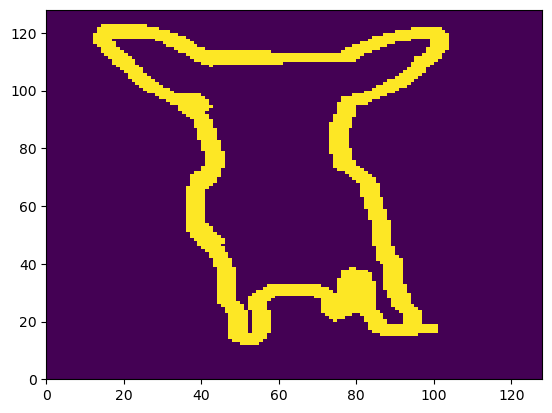

In [25]:
plt.pcolormesh(train_target[0, 2, ...])

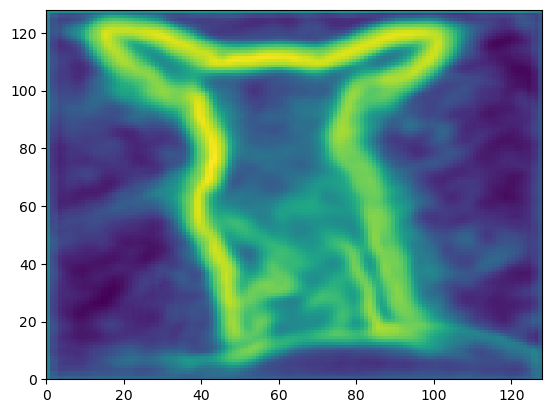

In [26]:
plt.pcolormesh(y_pred[0, 2, ...])

### Simple training loop example (old)

In [ ]:
N_epoch = 25 # number of epoches
N_batch = 100 # number of batches per epoch
N_sample = 32 # number of samples per batch

min_del = 0.0
max_tol = 3 # early stopping with 2-epoch patience
tol = 0

In [ ]:
def shuffle_ind(L):
    ind = np.arange(L)
    np.random.shuffle(ind)
    return ind

In [ ]:
# valid_input = input_data_process(image_to_array(sample_names[ind_valid], size=128, channel=3))
# valid_input = np.transpose(valid_input, [0, 3, 1, 2])
# valid_input = torch.from_numpy(valid_input).float()

# valid_target = image_to_array(label_names[ind_valid], size=128, channel=1)
# valid_target = valid_target[..., 0].astype(int)
# valid_target = valid_target - 1
# valid_target = to_categorical(valid_target, num_classes=3)
# valid_target = np.transpose(valid_target, [0, 3, 1, 2])
# valid_target = torch.from_numpy(valid_target.copy()).float()

# test_input = input_data_process(image_to_array(sample_names[ind_test], size=128, channel=3))
# test_input = np.transpose(test_input, [0, 3, 1, 2])
# test_input = torch.from_numpy(test_input).float()

# test_target = image_to_array(label_names[ind_test], size=128, channel=1)
# test_target = test_target[..., 0].astype(int)
# test_target = test_target - 1
# test_target = to_categorical(test_target, num_classes=3)
# test_target = np.transpose(test_target, [0, 3, 1, 2])
# test_target = torch.from_numpy(test_target.copy()).float()


# model = UNet(n_channels=3, n_classes=3).to("cuda")
# loss_func = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# y_pred = model(valid_input)
# record = loss_func(y_pred, valid_target).detach().numpy()
# print('Initial loss: {}'.format(record))

# for epoch in range(N_epoch):

#     for n_batch in range(N_batch):

#         ind_train_shuffle = shuffle_ind(L_train)[:N_sample]

#         # training batch preparation
#         ## input
#         train_input = input_data_process(
#             image_to_array(sample_names[ind_train][ind_train_shuffle], size=128, channel=3))

#         train_input = np.transpose(train_input, [0, 3, 1, 2])
#         train_input = torch.from_numpy(train_input).float()
        
#         ## target
#         train_target = target_data_process(
#             image_to_array(label_names[ind_train][ind_train_shuffle], size=128, channel=1))
        
#         train_target = train_target[..., 0].astype(int)
#         train_target = train_target - 1
#         train_target = to_categorical(train_target, num_classes=3)
#         train_target = np.transpose(train_target, [0, 3, 1, 2])
#         train_target = torch.from_numpy(train_target.copy()).float()
        
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         y_pred_ = model(train_input)
#         loss = loss_func(y_pred_, train_target)
#         loss.backward()
#         optimizer.step()
        
#     # on-epoch-end validation
#     y_pred = model(valid_input)
#     record_temp = loss_func(y_pred, valid_target).detach().numpy()
#     print('Validation loss: {}'.format(record_temp))
    
#     if record - record_temp > min_del:
#         print('Validation loss improved from {} to {}'.format(record, record_temp))
#         record = record_temp
#         print("Save to {}".format(save_dir))
#         torch.save(model.state_dict(), save_dir)
        
#     else:
#         print('Validation loss {} NOT improved'.format(record_temp))